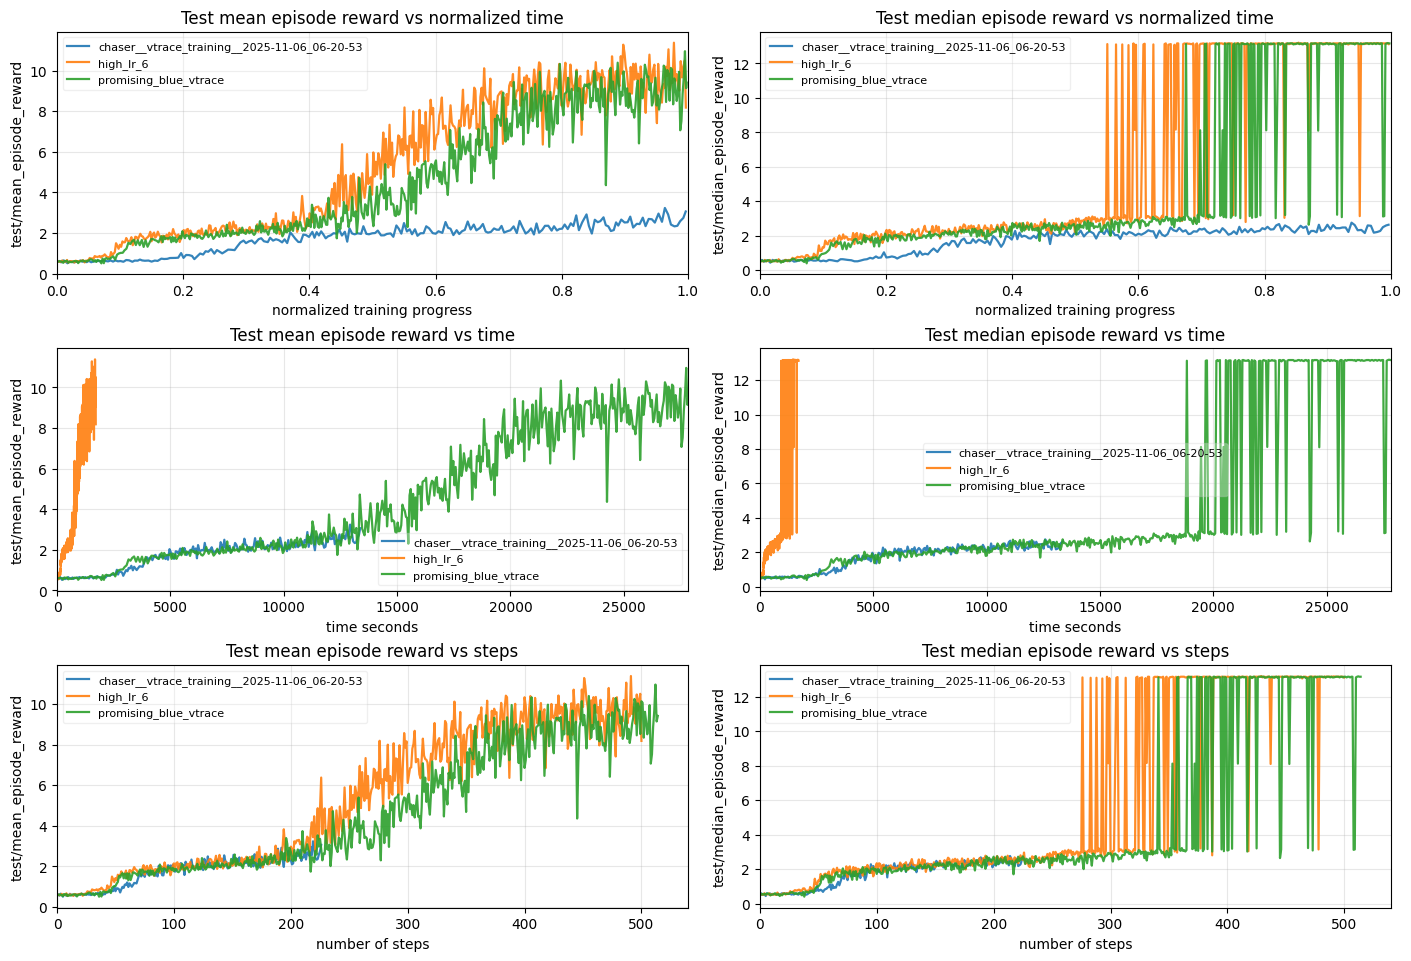

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT_DIR = "./outputs"
CSV_NAME = "sit_format.csv"

TIME_CANDIDATES = ["time", "timestamp", "wall_time", "train/total_time"]
STEP_CANDIDATES = ["step", "global_step", "steps", "train/steps", "train/global_step", "num_timesteps", "timesteps"]
Y_MEAN = "test/mean_episode_reward"
Y_MEDIAN = "test/median_episode_reward"

PLOTS = [
    {"x": "t_norm", "y": Y_MEAN, "xlabel": "normalized training progress", "ylabel": Y_MEAN, "title": "Test mean episode reward vs normalized time"},
    {"x": "t_norm", "y": Y_MEDIAN, "xlabel": "normalized training progress", "ylabel": Y_MEDIAN, "title": "Test median episode reward vs normalized time"},
    {"x": "t", "y": Y_MEAN, "xlabel": "time seconds", "ylabel": Y_MEAN, "title": "Test mean episode reward vs time"},
    {"x": "t", "y": Y_MEDIAN, "xlabel": "time seconds", "ylabel": Y_MEDIAN, "title": "Test median episode reward vs time"},
    {"x": "steps", "y": Y_MEAN, "xlabel": "number of steps", "ylabel": Y_MEAN, "title": "Test mean episode reward vs steps"},
    {"x": "steps", "y": Y_MEDIAN, "xlabel": "number of steps", "ylabel": Y_MEDIAN, "title": "Test median episode reward vs steps"},
]

def find_run_csvs(root, csv_name):
    paths = []
    for dirpath, _, filenames in os.walk(root):
        if csv_name in filenames:
            paths.append(os.path.join(dirpath, csv_name))
    return sorted(paths)

def infer_run_name(path, root):
    rel = os.path.relpath(os.path.dirname(path), root)
    return rel.replace("\\", "/")

def to_seconds(series):
    if series is None:
        return None
    if pd.api.types.is_numeric_dtype(series):
        return pd.to_numeric(series, errors="coerce").astype(float).values
    parsed = pd.to_datetime(series, errors="coerce", utc=True)
    if parsed.notna().any():
        return parsed.view("int64") / 1e9
    s = series.astype(str)
    if s.str.contains(":").any():
        def parse_duration(x):
            try:
                parts = [float(p) for p in str(x).split(":")]
                if len(parts) == 3:
                    return parts[0]*3600 + parts[1]*60 + parts[2]
                if len(parts) == 2:
                    return parts[0]*60 + parts[1]
            except:
                return np.nan
            return np.nan
        return s.map(parse_duration).values
    return pd.to_numeric(series, errors="coerce").values

def pick_time_column(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def build_time_seconds(df):
    tcol = pick_time_column(df, TIME_CANDIDATES)
    if tcol is not None:
        t = to_seconds(df[tcol])
    elif "train/total_time" in df.columns:
        t = to_seconds(df["train/total_time"])
    else:
        t = np.arange(len(df), dtype=float)
    if t is None or np.all(~np.isfinite(t)):
        t = np.arange(len(df), dtype=float)
    t = np.array(t, dtype=float)
    if np.isfinite(t).any():
        t0 = np.nanmin(t)
        if np.isfinite(t0) and t0 != 0:
            t = t - t0
    return t

def normalize_time_per_run(t, df):
    if "train/total_time" in df.columns:
        total = np.nanmax(to_seconds(df["train/total_time"]))
    else:
        total = np.nanmax(t)
    if not np.isfinite(total) or total <= 0:
        total = np.nanmax(t)
    if not np.isfinite(total) or total <= 0:
        total = 1.0
    return np.clip(t / float(total), 0.0, np.inf)

def build_steps(df):
    col = None
    for c in STEP_CANDIDATES:
        if c in df.columns:
            col = c
            break
    if col is None:
        steps = np.arange(len(df), dtype=float)
    else:
        steps = pd.to_numeric(df[col], errors="coerce").astype(float).values
        if steps is None or np.all(~np.isfinite(steps)):
            steps = np.arange(len(df), dtype=float)
    steps = np.array(steps, dtype=float)
    if np.isfinite(steps).any():
        s0 = np.nanmin(steps)
        if np.isfinite(s0):
            steps = steps - s0
    return steps

def load_runs(root):
    paths = find_run_csvs(root, CSV_NAME)
    data = []
    for p in paths:
        try:
            df = pd.read_csv(p)
            if Y_MEAN not in df.columns and Y_MEDIAN not in df.columns:
                continue
            t = build_time_seconds(df)
            tn = normalize_time_per_run(t, df)
            steps = build_steps(df)
            run = infer_run_name(p, root)
            sub = pd.DataFrame({
                "run": run,
                "t": t,
                "t_norm": tn,
                "steps": steps,
                Y_MEAN: pd.to_numeric(df.get(Y_MEAN, np.nan), errors="coerce"),
                Y_MEDIAN: pd.to_numeric(df.get(Y_MEDIAN, np.nan), errors="coerce"),
            })
            sub = sub.sort_values("t_norm")
            data.append(sub)
        except Exception:
            continue
    if not data:
        return pd.DataFrame()
    return pd.concat(data, ignore_index=True)

def plot_runs(ax, df, runs, x, y, xlabel, ylabel, title):
    for r in runs:
        d = df[df["run"] == r]
        if x == "t":
            d = d.sort_values("t")
        elif x == "steps":
            d = d.sort_values("steps")
        xv = d[x].values
        yv = d[y].values
        if np.all(np.isnan(yv)):
            continue
        ax.plot(xv, yv, label=r, linewidth=1.6, alpha=0.9)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if x == "t_norm":
        xmax = max(1.0, np.nanmax(df["t_norm"].values)) if np.isfinite(np.nanmax(df["t_norm"].values)) else 1.0
        ax.set_xlim(0, xmax)
    elif x == "t":
        xmax = np.nanmax(df["t"].values)
        if np.isfinite(xmax):
            ax.set_xlim(0, xmax)
    elif x == "steps":
        xmax = np.nanmax(df["steps"].values)
        if np.isfinite(xmax):
            ax.set_xlim(left=0)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8, framealpha=0.3)

df = load_runs(ROOT_DIR)

if df.empty:
    print(f"No {CSV_NAME} files with test rewards found under: {ROOT_DIR}")
else:
    runs = df["run"].unique().tolist()
    n = len(PLOTS)
    rows, cols = 3, 2  # three rows: normalized time, wall time, steps
    fig, axes = plt.subplots(rows, cols, figsize=(14, 9.5), constrained_layout=True)
    axes = axes.flatten()
    for i, cfg in enumerate(PLOTS):
        plot_runs(axes[i], df, runs, **cfg)
    for j in range(len(PLOTS), rows*cols):
        fig.delaxes(axes[j])
    plt.show()
